<p>Grant Cloud</p>
<p>CS-4641</p>
<p>HW1.py</p>

<p style="text-align: center;"><strong>All Functions</strong></p>
<p style="text-align: center;">This includes all functions supplied in the original hw1.py and any changes I made to those functions for this assignment</p>

In [ ]:
import os.path
import numpy
import matplotlib.pyplot as plt
import nbconvert

def linreg_model_sample(Theta,model_X):
	if model_X.shape[1]==1:
		## get a bunch of evenly spaced X values in the same range as the passed in data
		sampled_X = numpy.linspace(model_X.min(axis=0),model_X.max(axis=0),100)
		sampled_X = sampled_X.reshape(sampled_X.shape[0],1) # added so I could use the numpy.hstack for the sampled_Y
		## get the Y values for our sampled X values by taking the dot-product with the model
		## Note: we're appending a column of all ones so we can do this with a single matrix-vector multiply
		sampled_Y = numpy.hstack([numpy.ones((sampled_X.shape[0],1)),sampled_X]).dot(Theta)
		return sampled_X, sampled_Y
	elif model_X.shape[1]==2:
		## Unfortunately, plotting surfaces is a bit more complicated, first we need
		## a set of points that covers the area we want to plot. numpy.meshgrid is a helper function
		## that will create two NxN arrays that vary over both the X and Y range given.
		sampled_X, sampled_Y = numpy.meshgrid(model_X[:,0],model_X[:,1])
		## We can't just do a simple matrix multiply here, because plot_surface(...) is going to expect NxN arrays like
		## those generated by numpy.meshgrid(...). So here we're explicitly pulling out the components of Theta as
		## scalars and multiplying them across each element in the X and Y arrays to get the value for Z
		sampled_Z = sampled_X*Theta[1]+sampled_Y*Theta[2]+Theta[0]
		return sampled_X, sampled_Y, sampled_Z

def plot_helper(data_X, data_Y, model_X=None, model_Y=None, model_Z=None):
	import matplotlib.pyplot
	## 2D plotting
	## data_X.shape[1] is the number of columns in data_X, just as data_X.shape[0] is the number of rows
	if data_X.shape[1]==1:
		fig1 = matplotlib.pyplot.figure() ## creates a new figure object that we can plot into
		fig1.gca().scatter(data_X,data_Y) ## creates a scatterplot with the given set of X and Y points
		## If we were given a model, we need to plot that
		if not(model_X is None) and not(model_Y is None):
			## Plot the data from the model
			## Note: we're using plot(...) instead of scatter(...) because we want a smooth curve
			fig1.gca().plot(model_X,model_Y,color='r')
		## The graph won't actually be displayed until we .show(...) it. You can swap this with savefig(...) if you
		## instead want to save an image of the graph instead of displaying it. You can also use the interface to save an
		## image after displaying it
		plt.show()
	## 3D plotting
	elif data_X.shape[1]==2:
		## This import statement 'registers' the ability to do 3D projections/plotting with matplotlib
		from mpl_toolkits.mplot3d import Axes3D
		fig1 = matplotlib.pyplot.figure()
		## The format for 3D scatter is similar to 2D; just add the third dimension to the argument list
		fig1.gca(projection='3d').scatter(data_X[:,0],data_X[:,1],data_Y)
		if not(model_X is None) and not(model_Y is None) and not(model_Z is None):
			## Now, with our X, Y, and Z arrays (all NxN), we can use plot_surface(...) to create a nice 3D surface
			fig1.gca(projection='3d').plot_surface(model_X, model_Y, model_Z,linewidth=0.0,color=(1.0,0.2,0.2,0.75))
		plt.show()
	else:
		## Matplotlib does not yet have the capability to plot in 4D
		print('Data is not in 2 or 3 dimensions, cowardly refusing to plot! (data_X.shape == {})'.format(data_X.shape))

## Data loading utility function
def load_data(fname,directory='data'):
	data = numpy.loadtxt(os.path.join(directory,fname),delimiter=',')
	rows,cols = data.shape
	X_dim = cols-1
	Y_dim = 1
	return data[:,:-1].reshape(-1,X_dim), data[:,-1].reshape(-1,Y_dim)

def vis_linreg_model(train_X, train_Y, Theta):
	if train_X.shape[1] == 1:
		sample_X, sample_Y = linreg_model_sample(Theta,train_X)
		#NOTE: this won't work directly with 3D data. Write your own function, or modify this one
		#to generate plots for 2D-noisy-lin.txt or other 3D data.
		plot_helper(train_X, train_Y, sample_X, sample_Y)
	elif train_X.shape[1] == 2:
		sample_X, sample_Y, sample_Z = linreg_model_sample(Theta,train_X)
		plot_helper(train_X, train_Y, sample_X, sample_Y, sample_Z)

def linreg_closed_form(train_X, train_Y):
	'''
	Computes the optimal parameters for the given training data in closed form


	Args:
		train_X (N-by-D numpy array): Training data features as a matrix of row vectors (train_X[i][j] is the jth component of the ith example)
		train_Y (length N numpy array): The training data target as a length N vector


	Returns:
		A length D+1 numpy array with the optimal parameters
	'''
	if train_X.shape[1] <= 2:
		train_X = numpy.hstack([numpy.ones((train_X.shape[0],1)),train_X])
	Theta = numpy.dot(numpy.dot(numpy.linalg.inv(numpy.dot(numpy.transpose(train_X),train_X)),numpy.transpose(train_X)),train_Y)
	# TODO: compute the closed form solution here. Note: using numpy.linalg.lstsq(...) is *not* the correct answer
	return Theta

def loss(Theta, train_X, train_Y):
	'''
	Computes the squared loss for the given setting of the parameters given the training data


	Args:
		Theta (length D+1 numpy array): the parameters of the model
		train_X (N-by-D numpy array): Training data features as a matrix of row vectors (train_X[i][j] is the jth component of the ith example)
		train_Y (length N numpy array): The training data target as a length N vector


	Returns:
		The (scalar) loss for the given parameters and data.
	'''
	if train_X.shape[1] <= 2:
		train_X = numpy.hstack([numpy.ones((train_X.shape[0],1)),train_X])
	yHat = numpy.dot(train_X, Theta)
	sumSquared = sum([(yHat[m] - train_Y[m]) ** 2 for m in range(0,train_X.shape[0])])
	rv = sumSquared / (2 * train_X.shape[0]) # TODO: compute the loss here.
	return rv

def linreg_grad_desc(initial_Theta, train_X, train_Y, alpha=0.1, num_iters=500, print_iters=True):
	'''
	Fits parameters using gradient descent


	Args:
		initial_Theta ((D+1)-by-1 numpy array): The initial value for the parameters we're optimizing over
		train_X (N-by-D numpy array): Training data features as a matrix of row vectors (train_X[i][j] is the jth component of the ith example)
		train_Y (N-by-1 numpy array): The training data target as a vector
		alpha (float): the learning rate/step size, defaults to 0.1
		num_iters (int): number of iterations to run gradient descent for, defaults to 500


	Returns:
		The history of theta's and their associated loss as a list of tuples [ (Theta1,loss1), (Theta2,loss2), ...]
	'''
	cur_Theta = initial_Theta
	step_history = list()
	if train_X.shape[1] <= 2:
		tempTrain_X = numpy.hstack([numpy.ones((train_X.shape[0],1)),train_X])
	else:
		tempTrain_X = train_X
	for k in range(1,num_iters+1):
		cur_loss = loss(cur_Theta, train_X, train_Y)
		step_history.append((cur_Theta, cur_loss))
		if print_iters:
			print("Iteration: {} , Loss: {} , Theta: {}".format(k,cur_loss,cur_Theta))
		#TODO: Add update equation here
		lossDeriv = ((numpy.dot(numpy.dot(numpy.transpose(tempTrain_X),tempTrain_X), cur_Theta)) - (numpy.dot(numpy.transpose(tempTrain_X), train_Y))) / tempTrain_X.shape[0]
		cur_Theta = cur_Theta - (alpha * lossDeriv)
	return step_history

def apply_RFF_transform(X,Omega,B):
	'''
	Transforms features into a Fourier basis with given samples

		Given a set of random inner products and translations, transform X into the Fourier basis, Phi(X)
			phi_k(x) = cos(<x,omega_k> + b_k)                           #scalar form
			Phi(x) = sqrt(1/D)*[phi_1(x), phi_2(x), ..., phi_NFF(x)].T  #vector form
			Phi(X) = [Phi(x_1), Phi(x_2), ..., Phi(x_N)].T              #matrix form


	Args:
		X (N-by-D numpy array): matrix of row-vector features (may also be a single row-vector)
		Omega (D-by-NFF numpy array): matrix of row-vector inner products
		B (NFF length numpy array): vector of translations



	Returns:
		A N-by-NFF numpy array matrix of transformed points, Phi(X)
	'''
	Omega = Omega.T
	return numpy.sqrt(1.0/Omega.shape[1])*numpy.cos(X.dot(Omega)+B)

def random_fourier_features(train_X, train_Y, num_fourier_features=100, alpha=0.1, num_iters=500, print_iters=False):
	'''
	Creates a random set of Fourier basis functions and fits a linear model in this space.

		Randomly sample num_fourier_features's non-linear transformations of the form:

			phi_k(x) = cos(<x,omega_k> + b_k)
			Phi(x) = sqrt(1/D)*[phi_1(x), phi_2(x), ..., phi_NFF(x)]

		where omega_k and b_k are sampled according to (Rahimi and Recht, 2018).


	Args:
		train_X (N-by-D numpy array): Training data features as a matrix of row vectors (train_X[i][j] is the jth component of the ith example)
		train_Y (length N numpy array): The training data target as a length N vector
		num_fourier_features (int): the number of random features to generate


	Returns:
		Theta (numpy array of length num_fourier_features+1): the weights for the *transformed* model
		Omega (D-by-num_fourier_features numpy array): the inner product term of the transformation
		B (numpy array of length num_fourier_features): the translation term of the transformation
	'''
	# You will find the following functions useful for sampling:
	# 	numpy.random.multivariate_normal() for normal random variables
	#	numpy.random.random() for Uniform random variables

	# adding bias column to calculate mean and covariance for multivariate
	tempTrain_X = numpy.hstack([numpy.ones((train_X.shape[0],1)),train_X])
	mean = tempTrain_X.mean(axis=0)
	covar = numpy.cov(tempTrain_X.T)
	Omega = numpy.random.multivariate_normal(mean, covar, size=(num_fourier_features))
	# splicing omega to only use omeage values for the 1D train_X data
	Omega = Omega[:,1].reshape(Omega.shape[0],1)
	B = numpy.random.random(num_fourier_features,) * (2 * numpy.pi)
	Phi = apply_RFF_transform(train_X,Omega,B)
	initial_Theta = (numpy.random.random(size=num_fourier_features)-0.5)*0.2
	step_history = linreg_grad_desc(initial_Theta,Phi,train_Y,alpha=0.5,num_iters=num_iters,print_iters=print_iters)
	return step_history[-1][0], Omega, B

def rff_model_sample(Theta,Omega,B,model_X):
	sampled_X = numpy.array(numpy.linspace(model_X.min(axis=0),model_X.max(axis=0),100))
	sampled_X = sampled_X.reshape(sampled_X.shape[0],1)
	Phi = apply_RFF_transform(sampled_X,Omega,B)
	sampled_Y = Phi.dot(Theta)
	return sampled_X, sampled_Y

def vis_rff_model(train_X, train_Y, Theta, Omega, B):
	sample_X, sample_Y = rff_model_sample(Theta,Omega,B,train_X)
	plot_helper(train_X, train_Y, sample_X, sample_Y)

## Questions

### 1a)


Theta Hat 1D:  [[-1.66533454e-16]
 [ 5.00000000e-01]]

Loss 1D:  [1.01689101e-32]


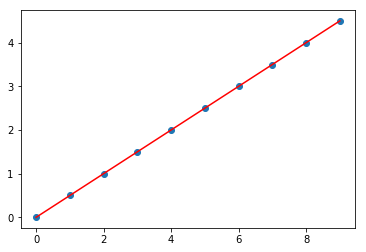


Theta Hat 2D:  [[ 2.93987438]
 [ 2.04156149]
 [-0.43683838]]

Loss 2D:  [0.10759283]


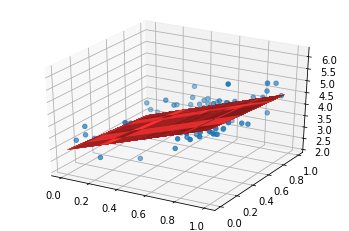

In [2]:
### 1D ###
data_X, data_Y = load_data('1D-no-noise-lin.txt')
thetaEst = linreg_closed_form(data_X,data_Y)
print('\nTheta Hat 1D: ', thetaEst)
lossEst = loss(thetaEst, data_X, data_Y)
print('\nLoss 1D: ', lossEst)
vis_linreg_model(data_X, data_Y, thetaEst)
### 2D ###
data_X, data_Y = load_data('2D-noisy-lin.txt')
thetaEst = linreg_closed_form(data_X,data_Y)
print('\nTheta Hat 2D: ', thetaEst)
lossEst = loss(thetaEst, data_X, data_Y)
print('\nLoss 2D: ', lossEst)
vis_linreg_model(data_X, data_Y, thetaEst)

### 1b)

In [3]:
data_X, data_Y = load_data('1D-no-noise-lin.txt')
data_X = numpy.hstack([data_X,data_X])
thetaEst = linreg_closed_form(data_X,data_Y)
print('\nTheta Hat (Column of X Duplicated): \n', thetaEst)
lossEst = loss(thetaEst, data_X, data_Y)
print('\nEstimated Loss (Column of X Duplicated): ', lossEst)
vis_linreg_model(data_X, data_Y, thetaEst)

LinAlgError: Singular matrix

<p>This raises an error when numpy.linalg tries to take the inverse of the covariance matrix. The identical data causes the covariance matrix to be almost zero and singular. Thus, the inverse errors out (most likely because the determinant for a zero matrix is 0 and taking the inverse raises a divide by zero error). We can avoid this error by adding noise to the data. Information on this issue was found <a href="https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests?rq=1">here</a>.</p>

<p>Let's add some noise to the duplicated column so we can still see a fit of the data</p>

noise_data_X: 
 [[0.07200787]
 [2.75007963]
 [0.90723352]
 [3.36440788]
 [3.40945822]
 [6.31034783]
 [6.64647435]
 [5.32635552]
 [8.51847869]
 [9.79482545]]

Theta Hat (Column of X Duplicated): 
 [[ 6.10622664e-15]
 [ 5.00000000e-01]
 [-1.44328993e-15]]

Estimated Loss (Column of X Duplicated):  [1.85258468e-29]


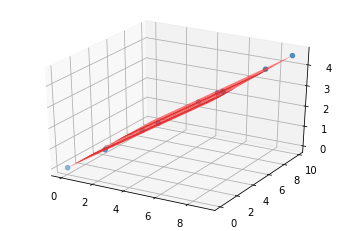

In [4]:
data_X, data_Y = load_data('1D-no-noise-lin.txt')
noise_data_X = numpy.random.normal(data_X,1)
print('noise_data_X: \n',noise_data_X)
data_X = numpy.hstack([data_X,noise_data_X])
thetaEst = linreg_closed_form(data_X,data_Y)
print('\nTheta Hat (Column of X Duplicated): \n', thetaEst)
lossEst = loss(thetaEst, data_X, data_Y)
print('\nEstimated Loss (Column of X Duplicated): ', lossEst)
vis_linreg_model(data_X, data_Y, thetaEst)

<p style="text-align: left;">If I duplicate a column of X (and add noise), then the dimension of theta hat will increase by one, and the additional theta value will be essentially 0. This shows that the optimal fit even with the new paramater remains the same (the original two fit parameters are almost unchanged). The new fit parameter = 0 implies that we should ignore that column of duplicated data. The plotted data will be in 3D because the input data is now 2D. </p>

### 1c)

In [5]:
data_X, data_Y = load_data('1D-no-noise-lin.txt')
data_X = numpy.insert(data_X,2,data_X[1],axis=0) # adding duplicate row
thetaEst = linreg_closed_form(data_X,data_Y)
print('\nTheta Hat (Row of X Duplicated): \n', thetaEst)
lossEst = loss(thetaEst, data_X, data_Y)
print('\nEstimated Loss (Row of X Duplicated): ', lossEst)
data_X = numpy.hstack([numpy.ones((data_X.shape[0],1)),data_X]) # adding bias column for plotting
vis_linreg_model(data_X, data_Y, thetaEst)

ValueError: shapes (2,11) and (10,1) not aligned: 11 (dim 1) != 10 (dim 0)

<p>Duplicating a row of X will create an error (unless you also duplicate a row of Y) because mathematically, you cannot take the dot product of two mismatched size matricies ((2x101) cannot be dotted with (100X1)). Logically speaking, you cannot fit data where you have an input X<sub>i</sub> but no matching output Y<sub>i</sub>.</p>

<p>If we add the y<sub>i</sub>:</p>


Theta Hat (Row of X Duplicated): 
 [[-8.32667268e-17]
 [ 5.00000000e-01]]

Estimated Loss (Row of X Duplicated):  [1.99596376e-33]


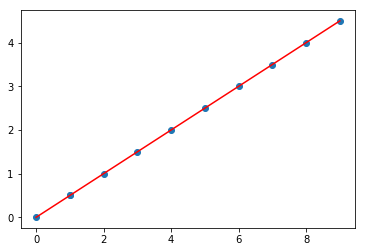

In [6]:
data_X, data_Y = load_data('1D-no-noise-lin.txt')
data_X = numpy.insert(data_X,2,data_X[1],axis=0) # adding duplicate row
data_Y = numpy.insert(data_Y,2,data_Y[1],axis=0) # adding matching duplicate y row
thetaEst = linreg_closed_form(data_X,data_Y)
print('\nTheta Hat (Row of X Duplicated): \n', thetaEst)
lossEst = loss(thetaEst, data_X, data_Y)
print('\nEstimated Loss (Row of X Duplicated): ', lossEst)
vis_linreg_model(data_X, data_Y, thetaEst)

<p>We get a shift in the y-intercept parameter to -8.32667268e-17 from -1.66533454e-16 , a difference of :</p>

In [7]:
str(-.832667268 + 1.66533454) + str('e-16')

'0.8326672719999999e-16'

<p>This shows essentialy no change in our line of fit with a matching duplicated row of data in the train_X and train_Y</p>

### 1d)


Theta Hat (Column of X Duplicated): 
 [[0.0004029 ]
 [0.24996803]
 [0.24996803]]

Estimated Loss (Column of X Duplicated):  [2.34961741e-08]


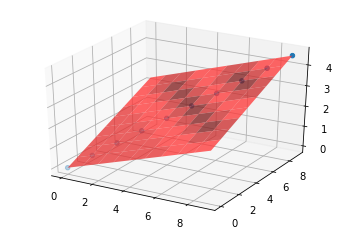

In [8]:
data_X, data_Y = load_data('1D-no-noise-lin.txt')
data_X = numpy.hstack([data_X,data_X])
testTheta = numpy.array([[0],[0],[0]])
gradDescList = linreg_grad_desc(testTheta,data_X,data_Y,alpha=.008,num_iters=2000,print_iters=False)
thetaEst = gradDescList[-1][0]
print('\nTheta Hat (Column of X Duplicated): \n', thetaEst)
lossEst = loss(thetaEst, data_X, data_Y)
print('\nEstimated Loss (Column of X Duplicated): ', lossEst)
vis_linreg_model(data_X, data_Y, thetaEst)

<p>Gradient descent plots in 3D (because of the 2D input data). Gradient descent doesn't come out to the same parameters as the closed_form_lin_alg with the duplicated column of data, but it does come out similar. You'll also notice the sum of the existing slope parameter and the duplicated slope parameter is equal to the original slope parameter in closed_form_lin_reg. So in closed_form_lin_reg the optimal weight for the duplicated column is 0 (i.e. we should ignore that column), but in gradient descent the optimal parameter for both columns is 1/2 the original parameter for the one column that got duplicated. This shows an equal weight for both columns will produce the same as the one weight in the original fit. </p>

### 2a)

In [9]:
data_X, data_Y = load_data('1D-no-noise-lin.txt')
testTheta = numpy.array([[0],[0]])
gradDescList = linreg_grad_desc(testTheta, data_X, data_Y, alpha=1, num_iters=10,print_iters=False)
for i in range(len(gradDescList)):
    print('Iteration {}'.format(i+1))
    print('Model Parameters: {},{}'.format(gradDescList[i][0][0],gradDescList[i][0][1]))
    print('Loss: {}\n'.format(gradDescList[i][1]))

Iteration 1
Model Parameters: [0],[0]
Loss: [3.5625]

Iteration 2
Model Parameters: [2.25],[14.25]
Loss: [2835.890625]

Iteration 3
Model Parameters: [-61.875],[-387.75]
Loss: [2258035.0078125]

Iteration 4
Model Parameters: [1747.125],[10955.8125]
Loss: [1.7979265e+09]

Iteration 5
Model Parameters: [-49298.90625],[-309132.65625]
Loss: [1.431572e+12]

Iteration 6
Model Parameters: [1391099.203125],[8723007.375]
Loss: [1.13986773e+15]

Iteration 7
Model Parameters: [-39253530.9375],[-2.46142635e+08]
Loss: [9.07602581e+17]

Iteration 8
Model Parameters: [1.10764186e+09],[6.94556337e+09]
Loss: [7.22664939e+20]

Iteration 9
Model Parameters: [-3.12550351e+10],[-1.95987381e+11]
Loss: [5.75411117e+23]

Iteration 10
Model Parameters: [8.81943214e+11],[5.53030063e+12]
Loss: [4.58162469e+26]



### 2b)

In [10]:
data_X, data_Y = load_data('1D-no-noise-lin.txt')
testTheta = numpy.array([[0],[0]])
gradDescList = linreg_grad_desc(testTheta, data_X, data_Y,print_iters=False)
print('Optimal Model Parameters: {},{}'.format(gradDescList[-1][0][0],gradDescList[-1][0][1]))
print('Loss: {}\n'.format(gradDescList[-1][1]))

Optimal Model Parameters: [2.86444118e+140],[1.79617243e+141]
Loss: [4.83301431e+283]



<p>No, you don't get the same model parameters and you don't get the same loss. The default alpha is too large and the model diverges. Compared to 2a), the increased num_iters allows the model to diverge even farther than it had originally in 2a), hence the even larger model parameters and larger loss.</p>

### 2c)

In [11]:
data_X, data_Y = load_data('1D-no-noise-lin.txt')

theta = numpy.linalg.lstsq(data_X, data_Y, rcond=None)
print('Best fit parameters using the numpy.linalg.lstsq method: \n\t',[theta[0],theta[1]])
print('\nOriginal loss with the closed_form_lin_reg: \n\t',1.01689101e-32,'\n\n')

testTheta = numpy.array([[0],[0]])
print('Two sets where the answers are the same:')
print('\talpha= {}, num_iters = {}'.format(.06, 2000))
gradDescList = linreg_grad_desc(testTheta, data_X, data_Y, alpha=.06, num_iters=2000,print_iters=False)
print('\tBest Fit Parameters: {}\n\tLoss: {}'.format(list(gradDescList[-1][0]),gradDescList[-1][1]), end='\n\n')
print('\talpha= {}, num_iters = {}'.format(.064, 1000))
gradDescList = linreg_grad_desc(testTheta, data_X, data_Y, alpha=.064, num_iters=1000,print_iters=False)
print('\tBest Fit Parameters: {}\n\tLoss: {}'.format(list(gradDescList[-1][0]),gradDescList[-1][1]), end='\n\n')

print('\nThe values above also match the numpy.linalg.lstsq method\n\n')


print('Two sets where the answers are noticeably different:')
print('\talpha= {}, num_iters = {}'.format(.1, 10))
gradDescList = linreg_grad_desc(testTheta, data_X, data_Y, alpha=.1, num_iters=10,print_iters=False)
print('\tBest Fit Parameters: {}\n\tLoss: {}'.format(list(gradDescList[-1][0]),gradDescList[-1][1]), end='\n\n')
print('\talpha= {}, num_iters = {}'.format(.05, 100))
gradDescList = linreg_grad_desc(testTheta, data_X, data_Y, alpha=.05, num_iters=100,print_iters=False)
print('\tBest Fit Parameters: {}\n\tLoss: {}'.format(list(gradDescList[-1][0]),gradDescList[-1][1]), end='\n\n')

Best fit parameters using the numpy.linalg.lstsq method: 
	 [array([[0.5]]), array([1.75043367e-30])]

Original loss with the closed_form_lin_reg: 
	 1.01689101e-32 


Two sets where the answers are the same:
	alpha= 0.06, num_iters = 2000
	Best Fit Parameters: [array([2.2930647e-15]), array([0.5])]
	Loss: [7.56561649e-31]

	alpha= 0.064, num_iters = 1000
	Best Fit Parameters: [array([9.52004449e-10]), array([0.5])]
	Loss: [1.31209015e-19]


The values above also match the numpy.linalg.lstsq method


Two sets where the answers are noticeably different:
	alpha= 0.1, num_iters = 10
	Best Fit Parameters: [array([27.86072179]), array([174.81666662])]
	Loss: [455247.5353425]

	alpha= 0.05, num_iters = 100
	Best Fit Parameters: [array([0.01902899]), array([0.49696536])]
	Loss: [5.24224316e-05]



<p>The first case is where the two sets of alpha and num_iters produce the same answer (and the same answer as the numpy.linalg.lstsq), this occurs because alpha is a small enough step to not start diverging and thus it will slowly make it's way down the gradient and both sets (in the same answers set) have a high enough num_iters to converge on the correct solution. In the second set of alpha and num_iters that produce vastly different results, the first alpha and num_iters actually diverges in gradient descent because the step is too large and each new theta (set of model parameters) bounces back and forth farther and farther from the correct values, the second set of values is working towards convergence (unlike set alpha=0.1, num_iters = 10) but isn't quite there yet. An increased num_iters would produce answers more similar to the first two sets i.e. alpha=0.06 num_iters = 2000.</p>

### 3a)

DATASET: 1D-exp-samp.txt

K: 3


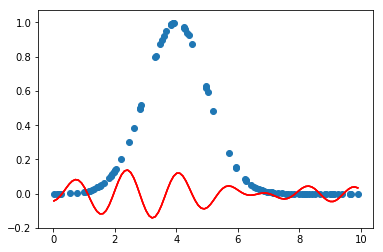

K: 10


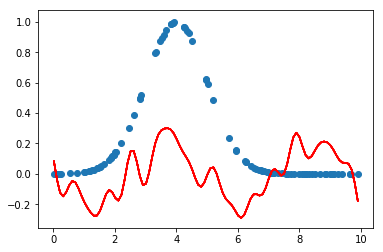

K: 80


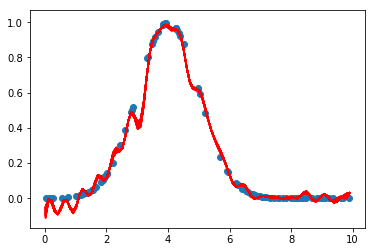

DATASET: 1D-exp-uni.txt

K: 3


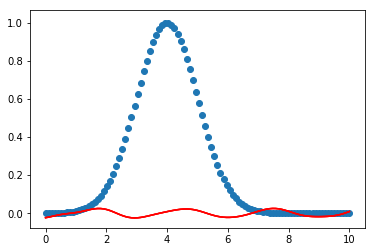

K: 40


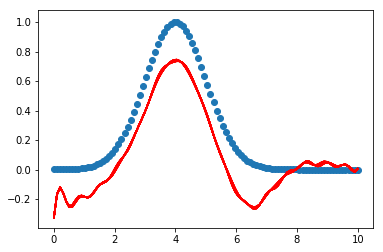

K: 200


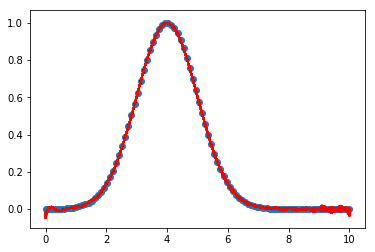

DATASET: 1D-quad-uni.txt

K: 3


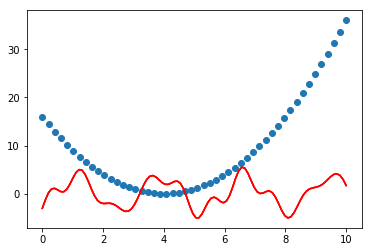

K: 35


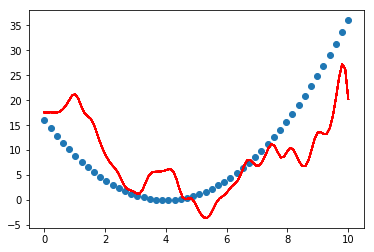

K: 300


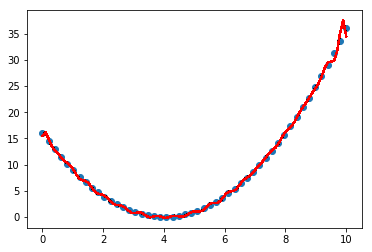

DATASET: 1D-quad-uni-noise.txt

K: 3


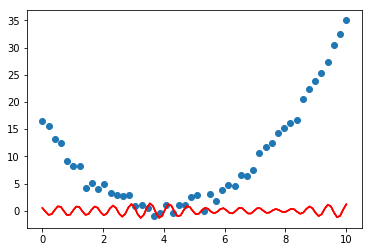

K: 35


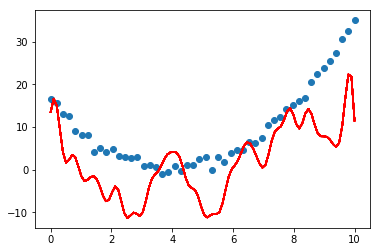

K: 400


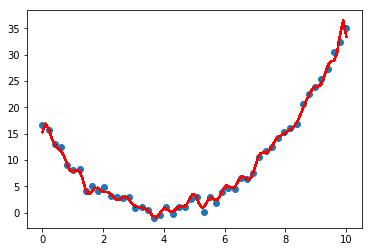

In [14]:
testList = ['1D-exp-samp.txt','1D-exp-uni.txt','1D-quad-uni.txt','1D-quad-uni-noise.txt']
kLists = [[3,10,80],[3,40,200],[3,35,300],[3,35,400]]
for i in range(len(testList)):
    print('DATASET: {}\n'.format(testList[i]))
    for k in kLists[i]:
        data_X, data_Y = load_data(testList[i])
        theta, omega, b = random_fourier_features(data_X, data_Y, num_fourier_features=k, alpha=0.005, num_iters=1000, print_iters=False)
        print('K: {}'.format(k))
        vis_rff_model(data_X, data_Y, theta, omega, b)

### 3b)

1d-exp-uni.txt:
	farPoint = 20


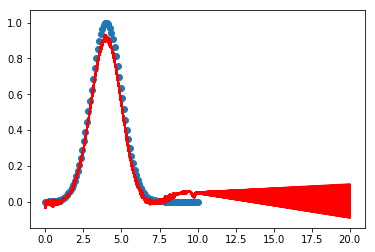

1d-exp-uni.txt:
	farPoint = 40


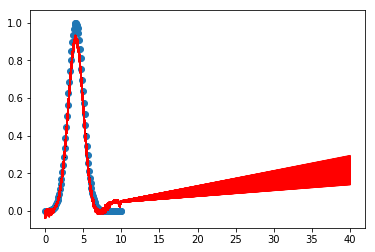

1d-exp-uni.txt:
	farPoint = 60


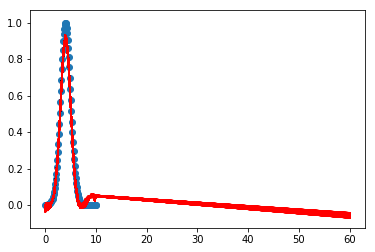

1d-quad-uni.txt:
	farPoint = 20


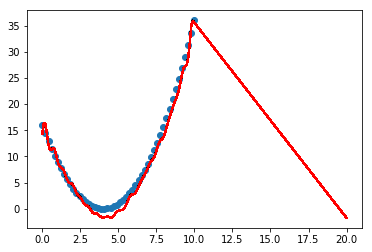

1d-quad-uni.txt:
	farPoint = 40


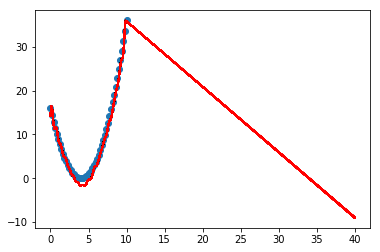

1d-quad-uni.txt:
	farPoint = 60


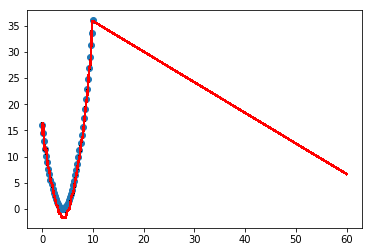

In [15]:
def rff_model_sample2(Theta,Omega,B,model_X,farPoint):
    sampled_X = numpy.array(numpy.linspace(model_X.min(axis=0),model_X.max(axis=0),100))
    sampled_X = sampled_X.reshape(sampled_X.shape[0],1)
    sampled_X = numpy.where(sampled_X==sampled_X[-1], farPoint, sampled_X)
    Phi = apply_RFF_transform(sampled_X,Omega,B)
    sampled_Y = Phi.dot(Theta)
    return sampled_X, sampled_Y

def vis_rff_model2(train_X, train_Y, Theta, Omega, B, farPoint):
    sample_X, sample_Y = rff_model_sample2(Theta,Omega,B,train_X,farPoint)
    plot_helper(train_X, train_Y, sample_X, sample_Y)
    
data_X, data_Y = load_data('1d-exp-uni.txt')
theta, omega, b = random_fourier_features(data_X, data_Y, num_fourier_features=k, alpha=0.001, num_iters=500, print_iters=False)
farPoints = [20,40,60]
for farPoint in farPoints:
    print('1d-exp-uni.txt:\n\tfarPoint = {}'.format(farPoint))
    vis_rff_model2(data_X, data_Y, theta, omega, b, farPoint)

data_X, data_Y = load_data('1d-quad-uni.txt')
theta, omega, b = random_fourier_features(data_X, data_Y, num_fourier_features=k, alpha=0.001, num_iters=500, print_iters=False)
farPoints = [20,40,60]
for farPoint in farPoints:
    print('1d-quad-uni.txt:\n\tfarPoint = {}'.format(farPoint))
    vis_rff_model2(data_X, data_Y, theta, omega, b, farPoint)

<p>If you try and predict a data point far away from the sample, qualitatively speaking, the model just creates a straight line from the end of the sample_X values in the original train_X range to the new farPoint that was added to the sample_X (and whatever Y the model predicts). Quantitatively, the actual y-value for the added farPoint should be some masssive number in the case with '1d-quad-uni.txt', but the model predicts values 'kind of' close to the mean of the train_X data. In the case of '1d-exp-uni.txt' the model predicts 'kind of' close to the mean as well (which appears to be a much better prediction). This is because the model is trying to minimize loss, and when it is uncertain of what the true value of the y for some farPoint should be, it picks a point close to the mean y-value to minimize loss because that's the safest bet (rather than choose a massive value in the case of '1d-quad-uni.txt' that could potentially have a massive loss).</p>